# Задание 08

In [151]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm.notebook import tqdm
import networkx as nx
import random
from itertools import product, combinations
from scipy.spatial.distance import euclidean
import seaborn as sns

In [11]:
def plot_matrix(A, normalize=True):
    fmt = '.2f' if normalize else 'd'
    plt.imshow(A,cmap='PiYG') 
    thresh=A.max() / 2
    for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                plt.text(j, i, format(A[i, j], fmt),
                        ha="center", va="center",
                         color="white" if A[i, j] > thresh else "black")
    plt.axis('off')

## 1. Random walk normalized Laplacian
Нормализованный Лапласиан определяется:  

$$
L^{norm}=D^{-1}L= I-D^{-1}A, $$

$$
L^{norm}_{ij}=
 \begin{cases}
   1, &\text{  $i=j$, $k_i \neq 0$},\\
   -\displaystyle \frac{1}{k_i}, &\text{  $ i \neq j,  (i,j) \in E$},\\
   0, &\text{  otherwise}.\\
 \end{cases}
$$

* напишите функцию, вычисляющую матрицу $L_{norm}$ для сети;

In [42]:
def normalized_laplacian_matrix(G):
    n = G.number_of_nodes()
    degrees = dict(G.degree())
    edges = G.edges()
    L = np.zeros(shape=(n, n))
    
    def Lij_norm(i, j):
        if i==j and degrees[i]!=0:
            return 1
        elif i!=j and (i, j) in edges:
            return -1/degrees[i]
        else:
            return 0
    
    for i, j in product(G.nodes(), repeat=2):
        if not (isinstance(i, int) and isinstance(j, int)):
            i_, j_ = int(i.replace('n', '')), int(i.replace('n', ''))
        else:
            i_, j_ = i, j
        L[i_, j_] = Lij_norm(i, j)
        
    return L

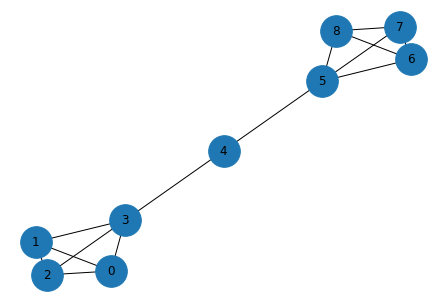

In [7]:
BR = nx.barbell_graph(4,1)
nx.draw(BR,node_size=1000,with_labels=True)

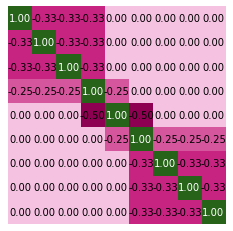

In [12]:
plot_matrix(normalized_laplacian_matrix(BR))

In [18]:
def check_eigvals(matrix):
    return all(map(lambda x : x>=0 and x<=2, np.linalg.eigvals(matrix)))

In [20]:
check_eigvals(normalized_laplacian_matrix(BR))

True

* убедитесь, что все собственные значения такой матрицы лежат $\left[0,2 \right]$.
* постройте спектры (огибающие гистограмм) сложных сетей, описывающие разные организмы (см. картинку 1 [статьи](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3888935/#B19)).

Если сети направленные или имеют мультиребра, предварительно сделайте их простыми (удалите направления и мультиребра). 

Похожи ли спектры различных организмов между собой? 

In [115]:
def plot_spectre(G):
    spec = np.linalg.eigvals(normalized_laplacian_matrix(G))
    sns.distplot(spec, norm_hist=True)
#     plt.hist(spec, bins=200, normed=True)
    plt.xlabel(r'$\lambda$',fontsize=14)
    plt.ylabel(r'$\rho(\lambda)$',fontsize=14)
    plt.show()
    
def print_info(G):
    print('Number of Nodes: {} \nNumber of Edges: {} \nDensity: {}'.format(nx.number_of_nodes(G), 
                                                                           nx.number_of_edges(G), 
                                                                           round(nx.density(G), 3)
                                                                          )
         )
    
def process(filename):
    G = nx.Graph(nx.read_graphml(filename))
    print_info(G)

    plot_spectre(G)
    return G

Number of Nodes: 65 
Number of Edges: 730 
Density: 0.351


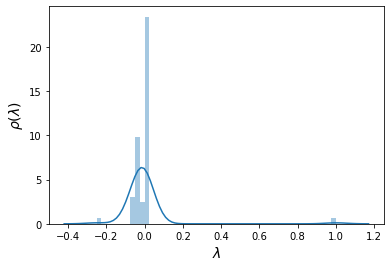

In [116]:
cat = process('cat.graphml')

Number of Nodes: 1781 
Number of Edges: 9016 
Density: 0.006


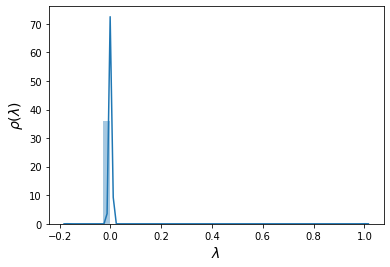

In [117]:
drosophila = process('drosophila.graphml')

Number of Nodes: 272 
Number of Edges: 2965 
Density: 0.08


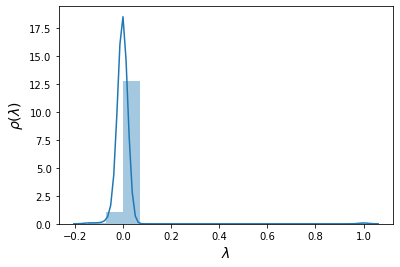

In [118]:
celegans = process('c-elegans.graphml')

Number of Nodes: 242 
Number of Edges: 3054 
Density: 0.105


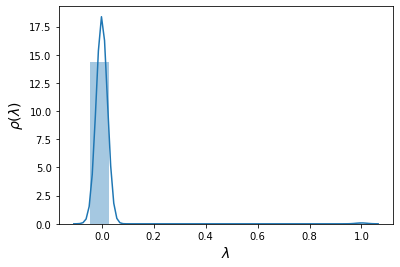

In [119]:
macaque = process('macaque.graphml')

Number of Nodes: 213 
Number of Edges: 16242 
Density: 0.719


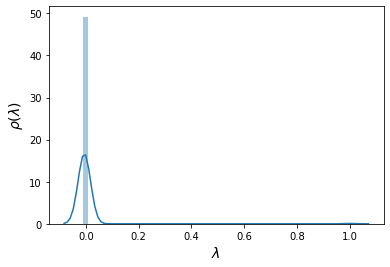

In [122]:
mouse = process('mouse.graphml')

Number of Nodes: 503 
Number of Edges: 23030 
Density: 0.182


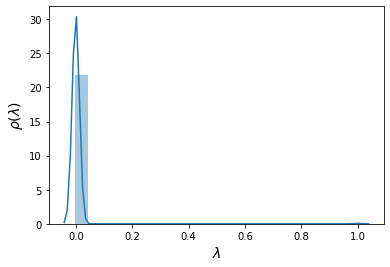

In [123]:
rat = process('rat.graphml')

## 2. Устойчивость коннектомов
Будем генерировать шум в сети двумы способами:

1) удалять ребро и ставить новое ребро между парой случайно выбранных вершин;

2) рандомизировать сеть, сохраняя степени вершин. 

* Постройте зависимости расстояния между исходным и зашумленным спектрами от числа шагов генерации шума. 

Расстояние определяется Евклидовой метрикой:

$$
s=\sum_{i}(\lambda_i-\lambda^{noise}_i)^2,
$$

Число шагов генерации шума измеряйте в количестве ребер графа: $N_{noise} = 0,~0.1E,~02E, ~ \dots E.$  

In [136]:
def add_noise(G, N_noise, preserve_degree=False):
    def step(G):
        edges = list(G.edges())
        nodes = list(G.nodes())
        combs = list(combinations(nodes, 2))
        old = random.choice(edges)
        new = random.choice(combs)
        G.remove_edge(old[0], old[1])
        G.add_edge(new[0], new[1])
        return G
    if preserve_degree:
        nx.connected_double_edge_swap(G, N_noise)
    else:
        for i in range(N_noise):
            G = step(G)
    return G

In [141]:
def shuffle(G, preserve_degree=False):
    N_noises = (np.linspace(0, 1, 11)*G.number_of_edges()).astype(int)
    noised = [np.linalg.eigvals(normalized_laplacian_matrix(add_noise(G, n, preserve_degree))) for n in N_noises]

    spec = np.linalg.eigvals(normalized_laplacian_matrix(G))
    distances = [euclidean(_, spec) for _ in noised]
    
    return distances

In [148]:
y = []
for creature in tqdm([cat, drosophila, celegans, macaque, mouse, rat]):
    y.append(shuffle(creature))

In [150]:
np.save('./distances.npy', y)

In [161]:
index = [str(round(_, 1))+'E' for _ in np.linspace(0, 1, 11)]
columns = ['cat', 'drosophila', 'celegans', 'macaque', 'mouse', 'rat']

In [162]:
df = pd.DataFrame(np.array(y).transpose(), index=index, columns=columns)

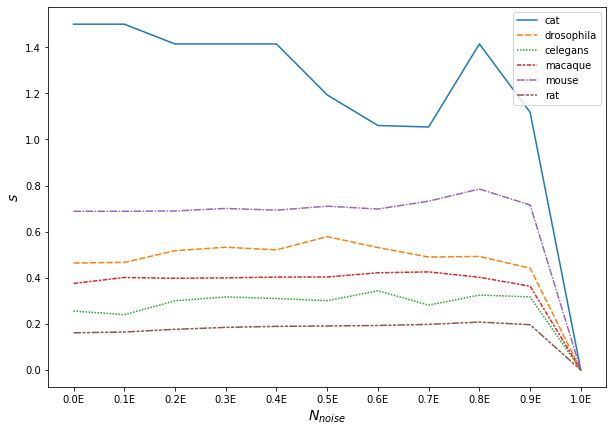

In [168]:
plt.figure(figsize=(10, 7))
sns.lineplot(data=df)
plt.xlabel(r'$N_{noise}$',fontsize=14)
plt.ylabel(r'$s$',fontsize=14)
plt.show()

## 3. Схожесть спектров различных организмов

* Вычислите расстояние между спектрами коннектомов различных организмов;

Так как спектры имеют различную размерность, то Евклидова метрика не годится для измерения расстояния. Можно использовать [Earth mover distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). 

Полезная функция (нужен scipy версии 1.0 и выше):

In [178]:
from scipy.stats import wasserstein_distance

In [172]:
specs = dict(zip(['cat', 'drosophila', 'celegans', 'macaque', 'mouse', 'rat'], 
                 [np.linalg.eigvals(normalized_laplacian_matrix(creature)) 
                  for creature in [cat, drosophila, celegans, macaque, mouse, rat]]
                )
            )

In [182]:
emd = pd.DataFrame(index=['cat', 'drosophila', 'celegans', 'macaque', 'mouse', 'rat'], 
                   columns=['cat', 'drosophila', 'celegans', 'macaque', 'mouse', 'rat']).fillna(0)
for pair in combinations(specs.keys(), 2):
    emd.loc[pair] = emd.loc[pair[::-1]] = wasserstein_distance(specs[pair[0]], specs[pair[1]])

In [183]:
emd

,cat,drosophila,celegans,macaque,mouse,rat
cat,0.000000,0.029361,0.026347,0.030268,0.021512,0.029613
drosophila,0.029361,0.000000,0.004244,0.009962,0.009546,0.003573
celegans,0.026347,0.004244,0.000000,0.005974,0.006108,0.003696
macaque,0.030268,0.009962,0.005974,0.000000,0.009815,0.007401
mouse,0.021512,0.009546,0.006108,0.009815,0.000000,0.009593
rat,0.029613,0.003573,0.003696,0.007401,0.009593,0.000000


* с чем можно сравнить найденные расстояния? 